In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from numpy.linalg import cholesky
from scipy.stats import norm

from HJM import*
from useful_functions import*

### Import des données

Les prix Forward de (2020-01-02 au 2022-12-30) 

In [3]:
df_forward = pd.read_csv("ForwardMarketData_2020-2022.csv", skiprows=6, sep=';')

In [4]:
df_forward.dropna(inplace=True)

In [5]:
df_forward['Trade Date'] = pd.to_datetime(df_forward['Trade Date'], format='%Y-%m-%d %H:%M:%S')

In [6]:
print(df_forward.head())
#print(df_forward.tail())

  Trade Date  Bank Holidays     1WAH     2WAH     3WAH     1MAH   2MAH   3MAH  \
0 2020-01-02              1  36.0000  41.0714  45.3571  44.7328  40.75  36.85   
1 2020-01-03              1  38.0357  41.7857  46.0357  46.0517  41.60  37.85   
2 2020-01-06              1  37.8214  40.5357  42.0000  43.1724  39.90  36.50   
3 2020-01-07              1  37.4643  40.3571  41.0714  43.0690  39.55  36.30   
4 2020-01-08              1  35.5714  41.0714  42.1429  43.1724  39.50  36.25   

    1QAH   2QAH   3QAH     1YAH     2YAH  
0  33.70  37.85  52.90  45.6535  46.9024  
1  35.00  38.95  54.15  47.0049  48.1028  
2  33.90  37.60  52.80  45.9816  47.5034  
3  34.05  37.75  52.50  46.1960  47.6542  
4  34.00  37.55  52.30  46.0963  47.6049  


Les prix spot (du 2005-04-22 00:00:00  au 2019-12-31 23:00:00)

In [7]:
df_spot = pd.read_csv("spot_fr.csv", skiprows=0, sep=';')

In [8]:
df_spot.dropna(inplace=True)

In [9]:
#print(df_spot.head())
#print(df_spot.tail())

On limite notre utilisation des prix spot à la période entre 2015-01-01 00:00:00 et 2019-12-31 23:00:00.

En effet, lors de la construction de la courbe forward initiale nous aimerions retrouver la dynamique des prix spot (notemment en terme de saisonnalité). Cette dynamique peut évoluer au cours du temps. Il est alors plus judicieux d'utiliser des données spots plus récentes. 

In [10]:
df_spot['date'] = pd.to_datetime(df_spot['date'])

# Filtrer le DataFrame pour conserver les données à partir du 1er janvier 2006 à 00:00:00
start_date = pd.Timestamp('2015-01-01 00:00:00') #prendre des années plus proches de 2019
df_spot = df_spot[df_spot['date'] >= start_date]

## I. Construction de la courbe "Forward Initiale"

### I.1 Shaping coefficients

##### I.1.a $C_{q}^{R}$ : "Shaping coefficient" pour passer des années aux quarters


$$C_{q}^{R}=\frac{1}{N_y}\sum_{y=1}^{N_y} \frac{\bar{S}_q(y)}{\bar{S}_R(y)}$$


où: \
$N_y$ est le nombre d'années dans les données historiques des prix spots, \
$\bar{S}_q(y)$  est la moyenne des prix spot pendant le trimestre $q$ de l'année $y$, \
 $\bar{S}_R(y)$  est la moyenne des prix spot pendant l'année  y .


In [11]:
def Get_CRq(df_spot, quarter):

    """"
    Calculer le "shaping coefficient" trimestriel CRq pour un trimestre "quarter".
    Ce coefficient permet de passer d'un prix annuel à un prix trimestriel (pour un trimestre de cette année) selon la relation : prix trimestriel_i = CRq_i * prix_annuel.

    Paramètres:
    df: Dataframe contenant les prix spots.
    month: Le trimestre dont on veut calculer le coefficient trimestriel

    Return: 
    Le coefficient trimestriel CRq pour le trimestre en question.
    """

    df_spot['date'] = pd.to_datetime(df_spot['date'])
    quarter_to_months = {1: [1, 2, 3], 2: [4, 5, 6], 3: [7, 8, 9], 4: [10, 11, 12]}

    if quarter not in quarter_to_months.keys():
        return None

    CRq_values = []
    # Boucle sur chaque année unique dans le DataFrame

    for year in df_spot['date'].dt.year.unique():

        # Filtrer les données pour l'année en cours et le trimestre en question.
        Yearly_prices = df_spot[df_spot['date'].dt.year == year]['price']
        quarterly_prices = df_spot[(df_spot['date'].dt.year == year) & (df_spot['date'].dt.month.isin(quarter_to_months[quarter]))]['price']

        # Calculer les moyennes
        Yearly_mean = Yearly_prices.mean()
        quarterly_mean = quarterly_prices.mean()

        # Calculer le CRq pour l'année en cours et l'ajouter à la liste
        if quarterly_mean != 0:
            CRq_values.append(quarterly_mean / Yearly_mean)

    # Calculer la moyenne des CRq par rapport au nombres d'années
    if len(CRq_values)!=0:
        return sum(CRq_values) / len(CRq_values)

    else:

        return None

In [12]:
CRq=[Get_CRq(df_spot, quarter) for quarter in range(1,5)]

In [13]:
# Vérifier le résultat
for i in range(len(CRq)):
    print("le \"Shaping coefficient\" du trimeste "+str(i+1)+" est : "+str(CRq[i]))

le "Shaping coefficient" du trimeste 1 est : 1.0488343849139483
le "Shaping coefficient" du trimeste 2 est : 0.7846953065600363
le "Shaping coefficient" du trimeste 3 est : 0.92350073207924
le "Shaping coefficient" du trimeste 4 est : 1.2421606356660582


##### I.1.b $C_{m}^{R}$ : "Shaping coefficient" pour passer des trimestres aux mois

$$C_{m}^{R}=\frac{1}{N_y}\sum_{y=1}^{N_y} \frac{\bar{S}_m(y)}{\bar{S}_q(y)}$$

où: \
$N_y$ est le nombre d'années dans les données historiques des prix spots, \
$\bar{S}_q(y)$  est la moyenne des prix spot pendant le trimestre $q$ de l'année $y$, \
 $\bar{S}_R(y)$  est la moyenne des prix spot pendant l'année  y .

In [14]:
def Get_CRm(df_spot, month):

    """"
    Calculer le "shaping coefficient" mensuel CRm pour un mois "month".
    Ce coefficient permet de passer d'un prix trimestriel à un prix mensuel (pour un mois de ce trimestre) selon la relation : prix mensuel_i = CRm_i * prix_trimestriel.

    Paramètres:
    df: Dataframe contenant les prix spots.
    month: Le mois dont on veut calculer le coefficient mensuel

    Return: 
    Le coefficient mensuel CRm pour le mois en question.
    """

    df_spot['date'] = pd.to_datetime(df_spot['date'])

    if month not in range(1,13):
        return None
    
    quarter_to_months = {1: [1, 2, 3], 2: [4, 5, 6], 3: [7, 8, 9], 4: [10, 11, 12]}
    for q in quarter_to_months.keys():
        if month in quarter_to_months[q]:
            quarter=q



    CRm_values = []
    # Boucle sur chaque année unique dans le DataFrame

    for year in df_spot['date'].dt.year.unique():
        
        # Filtrer les données pour l'année en cours, le mois et le trimestre
        monthly_prices = df_spot[(df_spot['date'].dt.year == year) & (df_spot['date'].dt.month == month)]['price']
        quarterly_prices = df_spot[(df_spot['date'].dt.year == year) & (df_spot['date'].dt.month.isin(quarter_to_months[quarter]))]['price']

        # Calculer les moyennes
        monthly_mean = monthly_prices.mean()
        quarterly_mean = quarterly_prices.mean()

        # Calculer le CRm pour l'année en cours et l'ajouter à la liste
        if quarterly_mean != 0:
            CRm_values.append(monthly_mean / quarterly_mean)

    # Calculer la moyenne des CRm de toutes les années
    if len(CRm_values) !=0 :
        return sum(CRm_values) / len(CRm_values)

    else:

        return None

In [15]:
CRm=[Get_CRm(df_spot, month) for month in range(1,13)]

In [16]:
# Vérifier le résultat
for i in range(len(CRm)):
    if i%3 ==0:
        print('Trimestre ' + str(int(i/3)+1)+" : ")
    print("le \"Shaping coefficient\" du mois "+str(i+1)+" est : "+str(CRm[i]))

Trimestre 1 : 
le "Shaping coefficient" du mois 1 est : 1.1195734367192558
le "Shaping coefficient" du mois 2 est : 1.0063386949307471
le "Shaping coefficient" du mois 3 est : 0.875435447875528
Trimestre 2 : 
le "Shaping coefficient" du mois 4 est : 1.045374033106816
le "Shaping coefficient" du mois 5 est : 0.9522685039496306
le "Shaping coefficient" du mois 6 est : 1.003948512811899
Trimestre 3 : 
le "Shaping coefficient" du mois 7 est : 0.9908139236557755
le "Shaping coefficient" du mois 8 est : 0.9411444886156831
le "Shaping coefficient" du mois 9 est : 1.0703096406528263
Trimestre 4 : 
le "Shaping coefficient" du mois 10 est : 0.9829387122311328
le "Shaping coefficient" du mois 11 est : 1.091939155848363
le "Shaping coefficient" du mois 12 est : 0.9280879111414191


##### I.1.c CHm : "Shaping coefficient" pour passer des mois aux heures

$$C_{H}^{m}=\frac{1}{\#H}\sum_{t \in H} \frac{S_t}{\bar{S}_m(t)}$$

où : \
$\#H$  est le nombre d'heures dans la classe  $H$ observées dans l'ensemble complet des données spots historiques. \
$\bar{S}_m(t) $ est la valeur moyenne des prix spot sur le mois  $m$ de l'instant  $t$. 

Dans notre cas une classe H est une heure dans un jour de la semaine; par exemple : $H_{\text{Jeudi}\ 14:00}$. \
ce qui nous donne 168 classes, si on considère toutes les heures de Lundi à dimanche.

In [17]:
def Get_CHm(df_spot, month,hour,day_of_week):
    """
    Calculer le coefficient horaire CHm pour une heure spécifique et une date donnée.
    df: DataFrame contenant les colonnes 'date' et 'price'.
    specific_date: Date spécifique pour laquelle calculer le coefficient.

    retour de la fonction: Le coefficient horaire CHm.
    """

    # Convertir la colonne 'date' en datetime si ce n'est pas déjà le cas
    df_spot['date'] = pd.to_datetime(df_spot['date'])

    H=0
    CHm=0

    for year in df_spot['date'].dt.year.unique():

        # Filtrer les prix spot pour le même jour de la semaine, la même heure, le même mois et pour chanque année
        same_weekday_prices = df_spot[(df_spot['date'].dt.dayofweek == day_of_week) & 
                                (df_spot['date'].dt.hour == hour) & 
                                (df_spot['date'].dt.month == month) & 
                                (df_spot['date'].dt.year == year)].copy()['price']
        
        same_weekday_prices.dropna(inplace=True)

        # Calculer la somme des prix pour le même jour de la semaine
        sum_same_weekday = same_weekday_prices.sum()

        # Calculer la somme des prix pour l'heure spécifiée sur tous les jours du mois
        same_hour_prices = df_spot[(df_spot['date'].dt.hour == hour) & 
                        (df_spot['date'].dt.month == month)&
                        (df_spot['date'].dt.year == year)].copy()['price']

        same_hour_prices.dropna(inplace=True)
        mean_same_hour=same_hour_prices.mean()
        # Calculer le coefficient horaire CHm
        if mean_same_hour != 0:
            CHm += sum_same_weekday /(mean_same_hour)
            H += same_weekday_prices.shape[0]
        else:
            CHm = None  # Retourne None si la somme des prix sur tous les jours du mois est nulle
    CHm=CHm/H
    
    return CHm

In [18]:
cnd=False

In [19]:
if cnd:
    CHm={}
    for month in range(1,13):
        for day_of_week in range(0,7):
            for hour in range(0,24):
                CHm[(month,day_of_week,hour)]=Get_CHm(df_spot, month,hour,day_of_week)
    with open('CHm.pkl', 'wb') as fp:
        pickle.dump(CHm, fp)
else:
    with open('CHm.pkl', 'rb') as fp:
        CHm = pickle.load(fp)
    #print(CHm_pkl)


### I.2 Supression des overlaps

##### I.2.a Creation d'un nouveau Data Frame avec les 4 quarters (QAH)

Plusieurs cas se présentent : \
\
si on est dans un mois du 1er trimestre (Janvier, Février, Mars) de l'année $y$ : 4QAH est un contrat qui délivre de l'électricité sur le 1er trimestre de l'année $y+1$. \
pour obtenir le prix du MWH de contrat on applique la formule suivante $1YAH * C_{q=1}^{R}$ avec $1YAH$ est le prix du MWH contrat qui délivre l'électricité sur l'année $y+1$ \

si on est dans un mois du 2ème trimestre (Avril, Mai, Juin) de l'année $y$ : 4QAH est un contrat qui délivre de l'électricité sur le 2ème trimestre de l'année $y+1$. \
pour obtenir le prix du MWH de contrat on applique la formule suivante $1YAH * C_{q=2}^{R}$ avec $1YAH$ est le prix du MWH contrat qui délivre l'électricité sur l'année $y+1$ \

si on est dans un mois du 3ème trimestre (Juillet, Aout, Septembre) de l'année $y$ : 4QAH est un contrat qui délivre de l'électricité sur le 3ème trimestre de l'année $y+1$. \
pour obtenir le prix du MWH de contrat on applique la formule suivante $1YAH * C_{q=3}^{R}$ avec $1YAH$ est le prix du MWH contrat qui délivre l'électricité sur l'année $y+1$

si on est dans un mois du 4ème trimestre (octobre, Novembre, Décembre) de l'année $y$ : 4QAH est un contrat qui délivre de l'électricité sur le 4ème trimestre de l'année $y+1$. \
On peut dans ce cas profiter de l'overlap entre les contrats $1QAH$, $2QAH$, $3QAH$ avec $1YAH$ pour déterminer le prix du MWH du contrat $4QAH$. \

Il suffit de résoudre l'éq suivante ayant pour inconnu 4QAH:

$$\frac{{\text{nb\_jours\_q1}(y+1) \times 1QAH + \text{nb\_jours\_q2}(y+1) \times 2QAH + \text{nb\_jours\_q3}(y+1) \times 3QAH + \text{nb\_jours\_q4}(y+1) \times 4QAH}}{{\text{nb\_jours}(y+1)}}=1YAH$$



In [20]:
def Get_4QAH_price(df_forward, date,CRq):

    # Convertir la date d'entrée en datetime
    input_date = datetime.strptime(date, '%d/%m/%Y')

    # Trouver la ligne correspondant à la date d'entrée
    date_data = df_forward[df_forward['Trade Date'] == input_date]

    # Vérifier si des données existent pour cette date
    if not date_data.empty:
        Q1AH_price = date_data['1QAH'].iloc[0]
        Q2AH_price = date_data['2QAH'].iloc[0]
        Q3AH_price = date_data['3QAH'].iloc[0]
        Y1AH_price = date_data['1YAH'].iloc[0]

    else:
        # Valeurs par défaut si une valeur donnée n'est trouvée
        Q1AH_price = Q2AH_price = Q3AH_price= Y1AH_price = np.nan

    # Initialiser la valeur du quatrième trimestre
    Q4AH_estimated_price = np.nan

    # Associe à chaque mois le trimestre correpsondant
    months_to_quarters = {}
    for i in range(1,13):
        months_to_quarters[i]=int((i-1)/3)+1

    # Le mois correspondant à la date en question
    month=input_date.month 
    # Le trimestre correspondant au mois en question
    quarter=months_to_quarters[month]

    if quarter in [1,2,3]:
        Q4AH_estimated_price=CRq[quarter-1]*Y1AH_price # "4QAH" va correspondre au même trimestre "quarter" mais de l'année prochaine.
        
    # Sinon on peut estimer le Q4AH_price en utilisant le overlap entre 1YAH_price et Q1AH_price,Q2AH_price et Q3AH_price
    else : 
        nb_days_1YAH=(datetime(input_date.year+2, 1, 1)-datetime(input_date.year+1, 1, 1)).days
        nb_days_1QAH= (datetime(input_date.year+1, 4, 1)-datetime(input_date.year+1, 1, 1)).days
        nb_days_2QAH= (datetime(input_date.year+1, 7, 1)-datetime(input_date.year+1, 4, 1)).days
        nb_days_3QAH= (datetime(input_date.year+1, 10, 1)-datetime(input_date.year+1, 7, 1)).days
        nb_days_4QAH= (datetime(input_date.year+2, 1, 1)-datetime(input_date.year+1, 10, 1)).days

        Q4AH_estimated_price = (nb_days_1YAH * Y1AH_price - (nb_days_1QAH*Q1AH_price + nb_days_2QAH*Q2AH_price + nb_days_3QAH*Q3AH_price))/nb_days_4QAH
        
    Q4AH_estimated_price=round(Q4AH_estimated_price,2) 
      
    return Q1AH_price, Q2AH_price, Q3AH_price, Q4AH_estimated_price

In [21]:
# Test de la fonction avec une date d'entrée
Get_4QAH_price(df_forward, "14/01/2021",CRq) 

(45.45, 46.6, 59.6, 54.22)

In [22]:
def Create_quarters_dataframe(df_forward,CRq):
    # Initialiser le DataFrame results avec les colonnes spécifiées
    df_forward_quarters = pd.DataFrame(columns=['Trade Date', '1QAH', '2QAH', '3QAH', '4QAH'])

    # Itérer sur chaque date dans le DataFrame filtré
    for index, row in df_forward.iterrows():

        date_str = row['Trade Date'].strftime('%d/%m/%Y')
        Q1AH_price, Q2AH_price, Q3AH_price, Q4AH_estimated_price = Get_4QAH_price(df_forward, date_str,CRq)
        
        # Ajouter les résultats au DataFrame results
        current_results = pd.DataFrame([[date_str, Q1AH_price, Q2AH_price, Q3AH_price, Q4AH_estimated_price]], columns=['Trade Date', '1QAH', '2QAH', '3QAH', '4QAH'])
        df_forward_quarters = pd.concat([df_forward_quarters, current_results], ignore_index=True)

    df_forward_quarters.dropna(inplace=True)

    return df_forward_quarters

In [23]:
df_forward_quarters=Create_quarters_dataframe(df_forward,CRq)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_11212\1065214432.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_forward_quarters = pd.concat([df_forward_quarters, current_results], ignore_index=True)


In [24]:
df_forward_quarters

,Trade Date,1QAH,2QAH,3QAH,4QAH
0,02/01/2020,33.700,37.850,52.900,47.88
1,03/01/2020,35.000,38.950,54.150,49.30
2,06/01/2020,33.900,37.600,52.800,48.23
3,07/01/2020,34.050,37.750,52.500,48.45
4,08/01/2020,34.000,37.550,52.300,48.35
...,...,...,...,...,...
754,22/12/2022,291.335,235.405,253.352,384.28
755,23/12/2022,281.655,224.036,246.249,378.08
756,28/12/2022,258.742,212.401,240.994,370.96
757,29/12/2022,251.143,212.142,235.117,362.24


##### I.2.b Creation d'un nouveau Data Frame avec les 12 mois (MAH)

Pour trouver le prix du MWH du contrat XMAH , il faut : 

- Identifier le mois de l'année correspondant à XMAH par rapport à l'instant de quotation : mois_maturité 
- Identifier le trimestre du mois de quotations : trimestre_quotation
- Identifier le trimestre du mois de la maturité du contrat : trimestre_maturité 

- le mois de la maturité du contrat se trouve dans (trimestre_maturité-trimestre_quotation)QAH par rapport à l'instant de quotation. 

- Pour trouver le prix de son MWH, il suffit d'appliquer la formule :

$$(trimestre\ maturité-trimestre\ quotation)QAH * C_{m=mois\ maturité}^{R=trimestre\ maturité}$$

Exemple :

- quotation : 05/03/2021 
- contrat   : 4MAH 

on trouve : 

- mois_maturité = 07 i.e Juillet 
- trimestre_quotation = 01 (car 03 (Mars) fait partie du 1er trimestre de l'année) 
- trimestre_maturité = 03 (car 07 (juillet)fait partie du 3ème trimestre de l'année) 

donc: 
$$4MAH=2QAH * C_{m=07}^{R=03}$$



In [25]:
def Create_months_dataframe(df_forward,df_forward_quarters, CRm):

    df_forward_months=df_forward_quarters.copy()
    
    # Associe à chaque mois le trimestre correpsondant
    months_to_quarters = {}
    for i in range(1,13):
        months_to_quarters[i]=int((i-1)/3)+1

    # Boucler sur chaque ligne du DataFrame
    for index, row in df_forward_months.iterrows():
        
        # Obtenir la date de la ligne actuelle
        date_str = datetime.strptime(row['Trade Date'], '%d/%m/%Y')
        month=date_str.month
        current_quarter=months_to_quarters[month]

        for i in range(4,13):

            MAH=(month+i)%12
            
            if month+i==12 or month+i==24 :
                MAH=12
            
            MAH_quarter=months_to_quarters[MAH]
            
            
            month_column = f'{i}MAH'

            if MAH_quarter>current_quarter:
                quarter_column = f'{MAH_quarter-current_quarter}QAH'
            else:
                quarter_column = f'{(4-current_quarter)+MAH_quarter}QAH'
            
            # Calculer la valeur mensuelle estimée et la stocker dans une nouvelle colonne pour la ligne actuelle
            df_forward_months.at[index, month_column] = row[quarter_column] * CRm[MAH-1]


    # Supprimer les colonnes trimestrielles
    df_forward_months.drop(['1QAH','2QAH', '3QAH', '4QAH'], axis=1, inplace=True)
    quarters_df = df_forward[['Trade Date', '1MAH', '2MAH', '3MAH']]
    # Fusionner quarters_df avec df_updated sur la colonne 'Trade Date'

    df_forward['Trade Date'] = pd.to_datetime(df_forward['Trade Date'], format='%d/%m/%Y')
    df_forward_months['Trade Date'] = pd.to_datetime(df_forward_months['Trade Date'], format='%d/%m/%Y')

    df_forward_months = pd.merge(quarters_df, df_forward_months, on='Trade Date', how='right')

    return df_forward_months

In [26]:
df_forward_months=Create_months_dataframe(df_forward,df_forward_quarters,CRm)

In [27]:
df_forward_months

,Trade Date,1MAH,2MAH,3MAH,4MAH,5MAH,6MAH,7MAH,8MAH,9MAH,10MAH,11MAH,12MAH
0,2020-01-02,44.7328,40.75,36.850,32.091449,33.833065,37.502307,35.622319,40.511220,51.997458,57.763581,49.095850,53.605176
1,2020-01-03,46.0517,41.60,37.850,33.329398,35.138198,38.592202,36.657578,41.688561,53.226131,59.128505,50.255960,55.194970
2,2020-01-06,43.1724,39.90,36.500,32.281902,34.033855,37.254604,35.387033,40.243642,51.899164,57.654387,49.003042,53.997027
3,2020-01-07,43.0690,39.55,36.300,32.424743,34.184447,37.403226,35.528204,40.404189,51.604282,57.326806,48.724615,54.243333
4,2020-01-08,43.1724,39.50,36.250,32.377129,34.134249,37.205063,35.339976,40.190127,51.407695,57.108418,48.538998,54.131376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,2022-12-22,283.1980,330.00,264.548,246.086274,224.168767,236.334500,251.024689,238.440838,271.165088,377.723688,419.610379,356.645622
755,2022-12-23,277.1500,322.00,249.718,234.201417,213.342427,224.920609,243.986938,231.755889,263.562679,371.629468,412.840356,350.891477
756,2022-12-28,243.6440,292.00,243.800,222.038490,202.262783,213.239668,238.780211,226.810175,257.938202,364.630945,405.065749,344.283492
757,2022-12-29,231.9420,280.00,244.280,221.767738,202.016145,212.979645,232.957197,221.279069,251.647992,356.059719,395.544040,336.190565


##### I.2.c Creation d'un nouveau Data Frame avec la granularité heure 

Nous avons fait le choix d'avoir en colonne du Dataframe sous la forme suivante :

$$XMAH\ Jour\ de\ la\ semaine\ HH:MM$$

En effet la construction des $C_{H}^{m}$ fait intervenir des classes H qui sont les heures des jours d'une semaine. \
 Ce qui veut dire que jeudi 11/03/2021 et jeudi 18/03/2021 appartiennent à la même classe  $H_{\text{Jeudi}\ 14:00}$ du mois de mars et donc ont le même coefficient shaping et par la suite le même prix par rapport à un même instant de quotation.

Pour une maturié donnée sous la forme $XMAH\ Jour\ de\ la\ semaine\ HH:MM$, on il faut: \
Identifier le mois de l'année correspondant à XMAH par rapport à l'instant de quotation : mois_maturité \
appliquer la formule:
$$XMAH*C_{Jour\ de \ la \ semaine \ HH:MM}^{mois\ maturité}$$


In [28]:
def Create_hours_dataframe(df_forward_months, CHm):

    df_forward_hours=df_forward_months.copy()
    
    # Boucler sur chaque ligne du DataFrame
    for index, row in df_forward_hours.iterrows():

        date_str = row['Trade Date']
        current_month=date_str.month
        # Obtenir la date de la ligne actuelle
        for MAH in range(1,13):

            month=(current_month+MAH)%12
            if current_month+MAH or current_month+MAH==24 :
                month=12

            month_column = f'{MAH}MAH'
            
            
            for day_of_week in range(0,7):
                for hour in range(0,24):
                    hour_column= f'{MAH}MAH ' + str(day_of_week) +' ' 
                    if hour // 10!=0:
                        hour_str= str(hour)+':00'
                    else:
                        hour_str= '0'+str(hour)+':00'
                    hour_column=hour_column+hour_str
                # Calculer la valeur mensuelle estimée et la stocker dans une nouvelle colonne pour la ligne actuelle
                    df_forward_hours.at[index, hour_column] = row[month_column] * CHm[(month,day_of_week,hour)]


    # Supprimer les colonnes trimestrielles
    for i in range(1,13):
        df_forward_hours.drop([str(i)+'MAH'], axis=1, inplace=True)
    
    return df_forward_hours

In [29]:
df_forward_hours=Create_hours_dataframe(df_forward_months,CHm)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_11212\1823543309.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forward_hours.at[index, hour_column] = row[month_column] * CHm[(month,day_of_week,hour)]
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_11212\1823543309.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forward_hours.at[index, hour_column] = row[month_column] * CHm[(month,day_of_week,hour)]
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_11212\1823543309.py:29: PerformanceWarning: DataFrame is hig

In [30]:
df_forward_hours.head()

,Trade Date,1MAH 0 00:00,1MAH 0 01:00,1MAH 0 02:00,1MAH 0 03:00,1MAH 0 04:00,1MAH 0 05:00,1MAH 0 06:00,1MAH 0 07:00,1MAH 0 08:00,...,12MAH 6 14:00,12MAH 6 15:00,12MAH 6 16:00,12MAH 6 17:00,12MAH 6 18:00,12MAH 6 19:00,12MAH 6 20:00,12MAH 6 21:00,12MAH 6 22:00,12MAH 6 23:00
0,2020-01-02,40.881144,39.550218,39.346341,38.536882,38.884426,41.948587,47.377929,48.737376,48.454349,...,38.417085,38.358037,39.058373,42.560890,45.376703,47.881320,48.549182,48.294954,49.136308,48.640636
1,2020-01-03,42.086482,40.716314,40.506427,39.673101,40.030892,43.185398,48.774818,50.174347,49.882975,...,39.556439,39.495640,40.216745,43.823138,46.722461,49.301359,49.989028,49.727261,50.593567,50.083194
2,2020-01-06,39.455100,38.170600,37.973835,37.192612,37.528033,40.485308,45.725260,47.037286,46.764132,...,38.697912,38.638432,39.343887,42.872007,45.708404,48.231330,48.904073,48.647987,49.495492,48.996196
3,2020-01-07,39.360603,38.079179,37.882886,37.103534,37.438151,40.388344,45.615745,46.924629,46.652129,...,38.874431,38.814680,39.523353,43.067567,45.916901,48.451336,49.127148,48.869894,49.721264,49.219691
4,2020-01-08,39.455100,38.170600,37.973835,37.192612,37.528033,40.485308,45.725260,47.037286,46.764132,...,38.794195,38.734568,39.441778,42.978676,45.822130,48.351333,49.025751,48.769027,49.618641,49.118102


In [31]:
#enregistrer le dataframe des courbes forwards initiales avec granularité heure 
df_forward_hours.to_csv('df_forward_hours.csv',index=False)

## II.  Résultas et observations 

On considère dans ce qui suit une construction d'une courbe forward initiale à partir d'une date de quotation le 02-12-2020. Ce choix de date de quotation a été fait pour pouvoir obsérver tous les prix forward sur l'année 2021 afin d'observer la dynamique de prix dans une année

In [32]:
t0='2020-12-02'
price_list_2=convert_columns_to_ordered_datetime(df_forward_hours, t0)
price_list_2

df_spot_2017=df_spot[df_spot['date'].dt.year == 2017]
df_spot_2017_month_3=df_spot[(df_spot['date'].dt.year == 2017) & (df_spot['date'].dt.month ==3)]

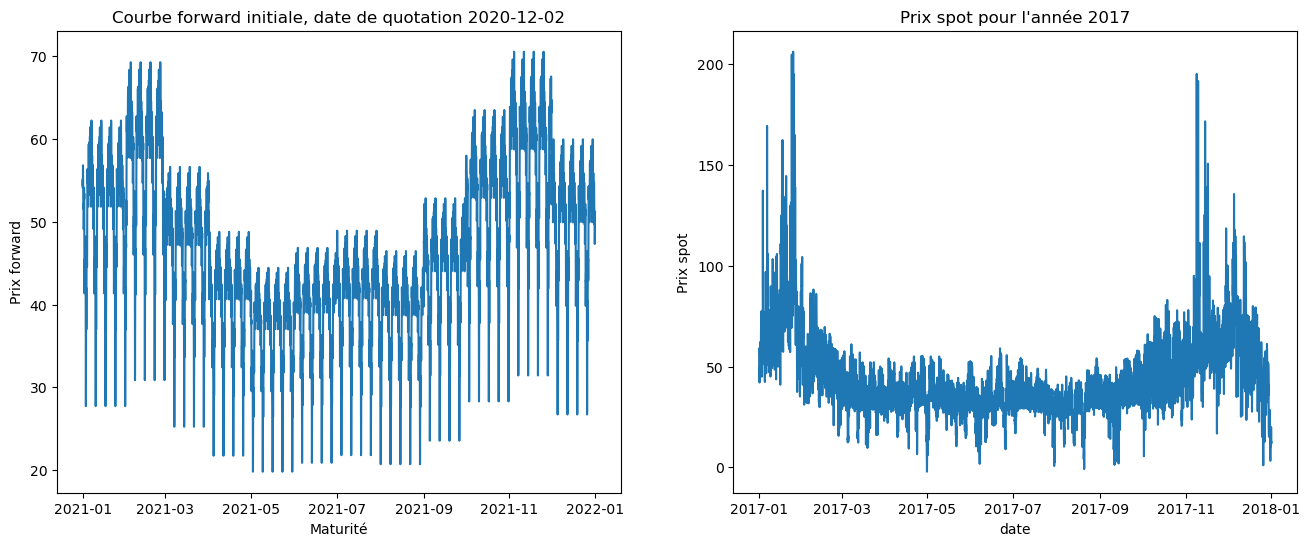

In [50]:
fig,ax=plt.subplots(1,2,figsize=(16,6))

price_list_2_transposed = price_list_2.transpose()
ax[0].plot(price_list_2_transposed)
ax[0].set_xlabel('Maturité')
ax[0].set_ylabel('Prix forward')
ax[0].set_title('Courbe forward initiale, date de quotation ' +t0)

ax[1].plot(df_spot_2017['date'],df_spot_2017['price'])
ax[1].set_xlabel('date')
ax[1].set_ylabel('Prix spot')
ax[1].set_title('Prix spot pour l\'année 2017')

plt.show()

on remarque qu'il y a deux piques: un vers de le début et un autre vers la fin de l'anne. Cela correspond au période de fortes consommations en hiver. On constate une baisse de ces prix le reste de l'année. Cette observation se retrouve sur les prix spot et donc la courbe forward initiale reproduit la saisonnalité des prix spots, ce qui valide en partie notre implémentation.

On remarque aussi qu'il y a un motif qui se répètent quatre fois. Ce qui traduit le fait que les prix dans chaque semaine d'un même mois sont identiques par consruction.

On regarde une baisse critique des prix qui se répètent quatre fois dans un même mois, qu'on cherchera à expliquer ci-dessous.

In [34]:
price_list_copy=price_list_2.copy()
price_list_copy.columns = pd.to_datetime(price_list_2.columns)
selected_columns = price_list_2.loc[:, '2021-02-06':'2021-02-14']

price_list_copy_2=price_list_2.copy()
price_list_copy_2.columns = pd.to_datetime(price_list_2.columns)
selected_columns_2 = price_list_2.loc[:, '2021-02-13':'2021-02-21']

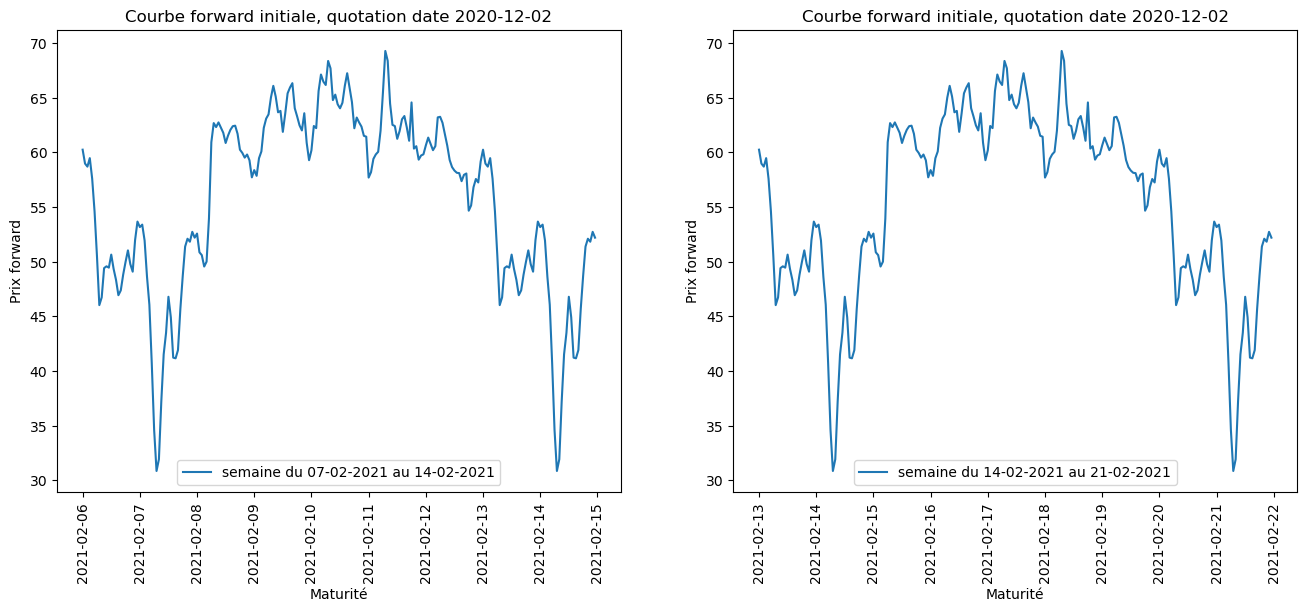

In [52]:
fig,ax=plt.subplots(1,2,figsize=(16,6))
selected_columns_transposed = selected_columns.transpose()
selected_columns_2_transposed = selected_columns_2.transpose()

ax[0].plot(selected_columns_transposed,label='semaine du 07-02-2021 au 14-02-2021')
ax[1].plot(selected_columns_2_transposed,label='semaine du 14-02-2021 au 21-02-2021')

for i in range(2):
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_xlabel('Maturité')
    ax[i].set_ylabel('Prix forward')
    ax[i].set_title('Courbe forward initiale, quotation date ' +t0)
    ax[i].legend()

plt.show()

Nous proposons de faire un zoom sur les prix forward sur une semaine. Ci dessus nous montrons ces prix pour la semaine du 07-02-2021 au 14-02-2021, et 14-02-2021 au 21-02-2021.\
La première observation qu'on peut faire c'est que les prix sur ces deux semaines sont identiques, cela est dû à la manière dont est construit la courbe forward initiale (passage de la granularité mois à la granularité heure, paragraphe I.2.c).

Nous remarquons que la baisse de prix se fait le 07-02-2021, cette date correspond à un dimanche. Les autres baisses de prix se retrouve aussi les dimanches cela est probablement dû à la baisse de l'activité pendant ce jour de le semaine et donc la baisse de consommation de l'énergie.

Vérifions ci-dessous, si ce même comportement se trouve dans la dynamique des prix spot.

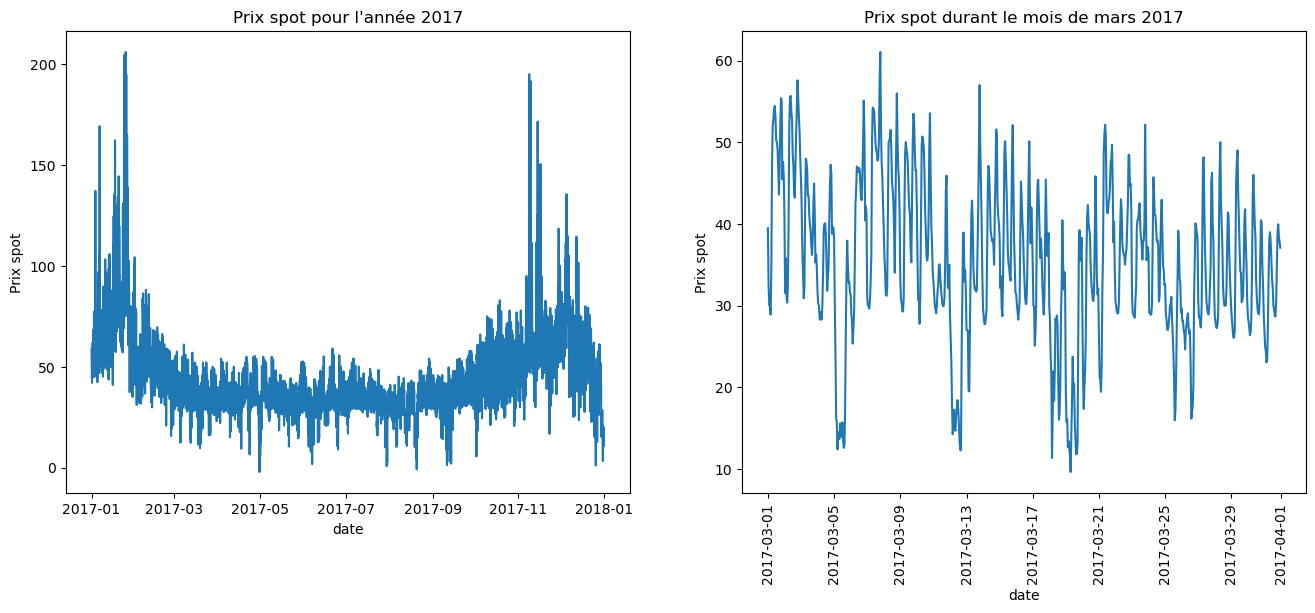

In [53]:
fig,ax=plt.subplots(1,2,figsize=(16,6))

ax[0].plot(df_spot_2017['date'],df_spot_2017['price'])
ax[0].set_xlabel('date')
ax[0].set_ylabel('Prix spot')
ax[0].set_title('Prix spot pour l\'année 2017')


ax[1].plot(df_spot_2017_month_3['date'],df_spot_2017_month_3['price'])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_xlabel('date')
ax[1].set_ylabel('Prix spot')
ax[1].set_title('Prix spot durant le mois de mars 2017')

plt.show()

On observe le même comportement sur la courbe des prix spots

La construction de la courbe forward initiale, a réussi à reporduire la dynamique des prix spot que ce soit sur l'échelle annuelle (reproduction de la saisonnalité des prix) ou à l'échelle hébdomadaire (baisse des prix le dimanche). Cele permet entre autre à valider cette construction.

In [38]:
N = 2  # Number of factors
vecteur_ai = [80,20]  # Coefficients for each factor
rho_matrix = np.array([[1, 0.7], [0.7, 1]])  # Correlation matrix
beta = [0.6,1.3]  # Volatility parameters for each factor
num_steps = 100
maturities=price_list_2.columns
t0='2020-12-02'
t='2020-12-25'
F_t=HJM(N, vecteur_ai, rho_matrix, beta, num_steps, price_list_2.values[0], maturities,t0,t)

# III. Simulation HJM

On considère ci-dessous une courbe forward initiale à la date de quotation 02-12-2020.\
On modélise la dynamique de nos prix forward horaire selon un modèle HJM Markovien à 2 facteurs:
$$dF(t, T) = F(t, T)(e^{-\lambda(T - t)}\sigma_{1} dW_{1}(t) + \sigma_{2} dW_{2}(t)) \quad 0 \leq t < T$$
On se propose alors de projeter la courbe à la date de quotation 25-12-2020 grâce à une simulation de HJM.

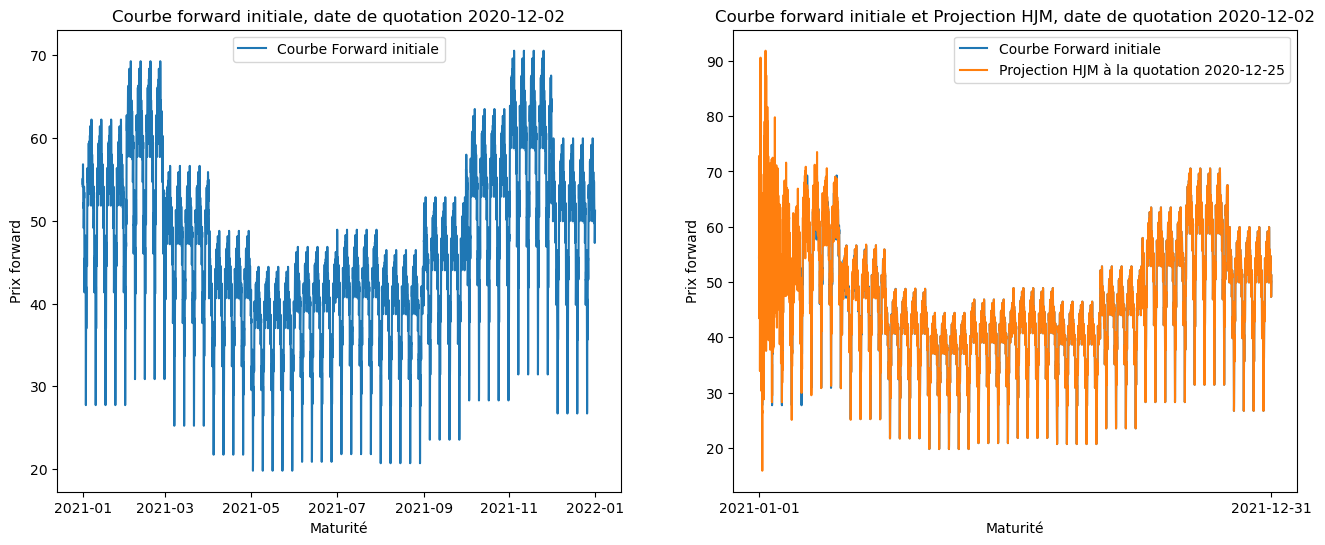

In [48]:
fig,ax=plt.subplots(1,2,figsize=(16,6))

price_list_transposed = price_list_2.transpose()
ax[0].plot(price_list_transposed,label='Courbe Forward initiale')

ax[1].plot(price_list_2.values[0],label='Courbe Forward initiale')
ax[1].plot(F_t,label='Projection HJM à la quotation '+t)


# Set the specific x-axis tick labels for the first and last values
start_date=str(price_list_2.columns[0]).split()[0]
end_date=str(price_list_2.columns[-1]).split()[0]

ax[0].set_title('Courbe forward initiale, date de quotation ' +t0)
ax[1].set_title('Courbe forward initiale et Projection HJM, date de quotation ' +t0)
ax[1].set_xticks(ticks=[0, len(price_list_2.values[0]) - 1], 
           labels=[start_date, end_date])
for i in range(2):
    ax[i].set_xlabel('Maturité')
    ax[i].set_ylabel('Prix forward')
    
    ax[i].legend()
plt.show()

On remarque une baisse de la variance du résultats de la simulation par rapport à la coubre forward initiale (quotation 02-12-2020) pour les grandes maturités.\
en effet le terme de volatilité $\sigma_1\exp^{-\lambda(T-t)} $ tends vers 0 pour T grand, il ne reste alors que la contribution du terme $\sigma_2$ pour la volatilité.